# Auto ARIMA: ARIMA simplified

This file explores the use of the auto_arima function fromt the 'Pmdarima library'. With this, we do not need to determine the (p,d,q) for every sequence by ourselves, and hopefully it will save a lot of time when doing ARIMA forecasting for all the mice's data. There is also another useful function that can be used as an easier method compated to what was done for determining the lag(differencing amount d) in the arima_original_index.ipynb file. using argument autolag in the adfuller function will determine a proper lag interval. 
In the end, the problem seems to be the seasonal term in the data that is causing trouble. if no good ADF result, maybe use seasonal differencing.

In [2]:
# upload data
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

mouse_df_list = list()

# pull 16 mice PCA data
for i in range(1,17):
    df = pd.read_excel("data/originalVars/{}.xlsx".format(i))
    mouse_df_list.append(df)


# create array that will hold all graphs
graphs = []
for mouse in mouse_df_list:
    # create mouse array and iterate through 13 variables
    mouseN = []
    for i in range(13):
        dfAti = pd.DataFrame(mouse.iloc[:, i])
        dfAti.insert(0, 'DateTime', mouse['DateTime'])
        mouseN.append(dfAti)
    graphs.append(mouseN)

print(len(graphs))
print(len(mouseN))
dfAti


16
13


,DateTime,Stilltime_M
0,2022/11/04 14:01:00,15.44444
1,2022/11/04 14:31:00,0.00000
2,2022/11/04 15:01:00,26.77778
3,2022/11/04 15:31:00,19.27778
4,2022/11/04 16:01:00,8.00000
...,...,...
1136,2022/11/28 06:01:00,38.00000
1137,2022/11/28 06:31:00,86.61111
1138,2022/11/28 07:01:00,82.27778
1139,2022/11/28 07:31:00,85.72222


In [3]:
df = graphs[15][2]
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime',inplace=True)
df.head()

,VH2O_M
DateTime,
2022-11-04 14:01:00,0.201321
2022-11-04 14:31:00,0.218149
2022-11-04 15:01:00,0.208647
2022-11-04 15:31:00,0.199221
2022-11-04 16:01:00,0.191377


<Axes: xlabel='DateTime'>

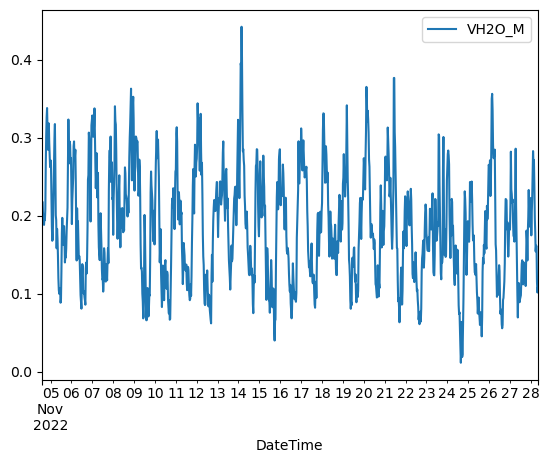

In [4]:
df.plot()

In [5]:
# split data into train and test sets

# first 21 days are for training, last 2 days + extra points for test
TEST_SIZE = 133
train, test = df.iloc[:-TEST_SIZE], df.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], df.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((1008, 1), (1008,), (133, 1), (133,))

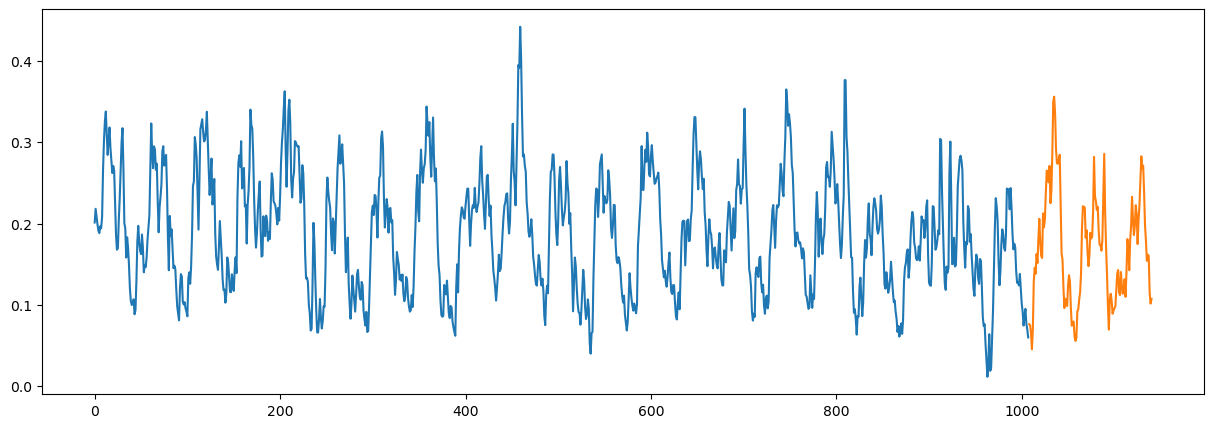

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

In [7]:
from pmdarima.arima import auto_arima

model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4466.383, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4350.538, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4436.063, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4467.324, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4352.512, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4467.155, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4500.582, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4482.919, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4483.444, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-4481.466, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4480.595, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4482.992, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.210 seconds


In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1008
Model:               SARIMAX(1, 1, 2)   Log Likelihood                2255.291
Date:                Sun, 02 Jul 2023   AIC                          -4500.582
Time:                        20:17:15   BIC                          -4476.009
Sample:                    11-04-2022   HQIC                         -4491.246
                         - 11-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.223e-05   4.67e-05     -0.262      0.793      -0.000    7.93e-05
ar.L1          0.8851      0.041     21.641      0.000       0.805       0.965
ma.L1         -0.5488      0.045    -12.078      0.000      -0.638      -0.460
ma.L2         -0.3992      0.028    -14.291      0.000      -0.454      -0.344
sigma2         0.0007   2.42e-05     27.437      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):               129.72
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.51
Prob(H) (two-sided):                  0.47   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# Forecast

prediction, confint = model.predict(n_periods=TEST_SIZE, return_conf_int=True)

prediction

2022-11-25 14:01:00    0.060449
2022-11-25 14:31:00    0.066278
2022-11-25 15:01:00    0.071425
2022-11-25 15:31:00    0.075969
2022-11-25 16:01:00    0.079979
                         ...   
2022-11-28 06:01:00    0.098491
2022-11-28 06:31:00    0.098384
2022-11-28 07:01:00    0.098278
2022-11-28 07:31:00    0.098171
2022-11-28 08:01:00    0.098065
Freq: 30T, Length: 133, dtype: float64

In [10]:
cf= pd.DataFrame(confint)


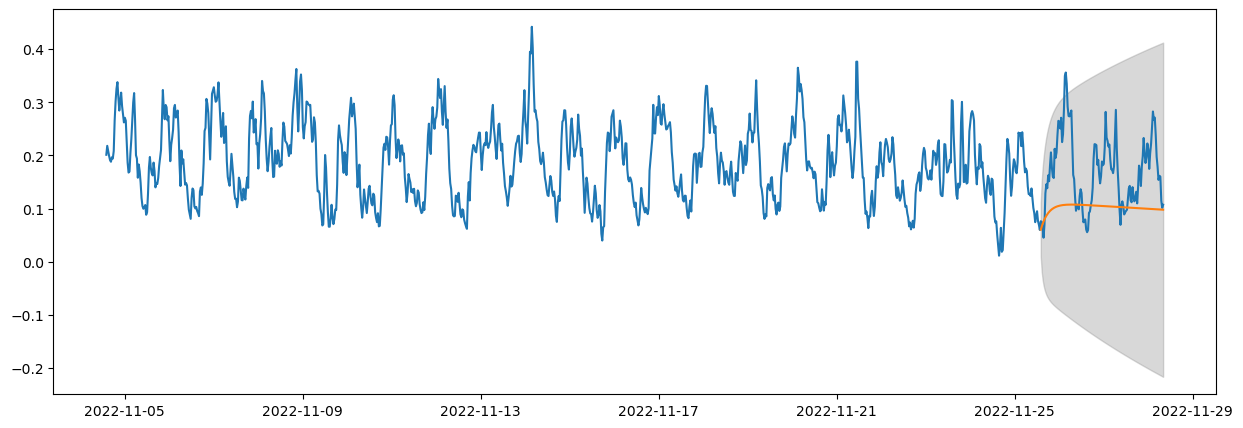

In [13]:
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df.VH2O_M)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

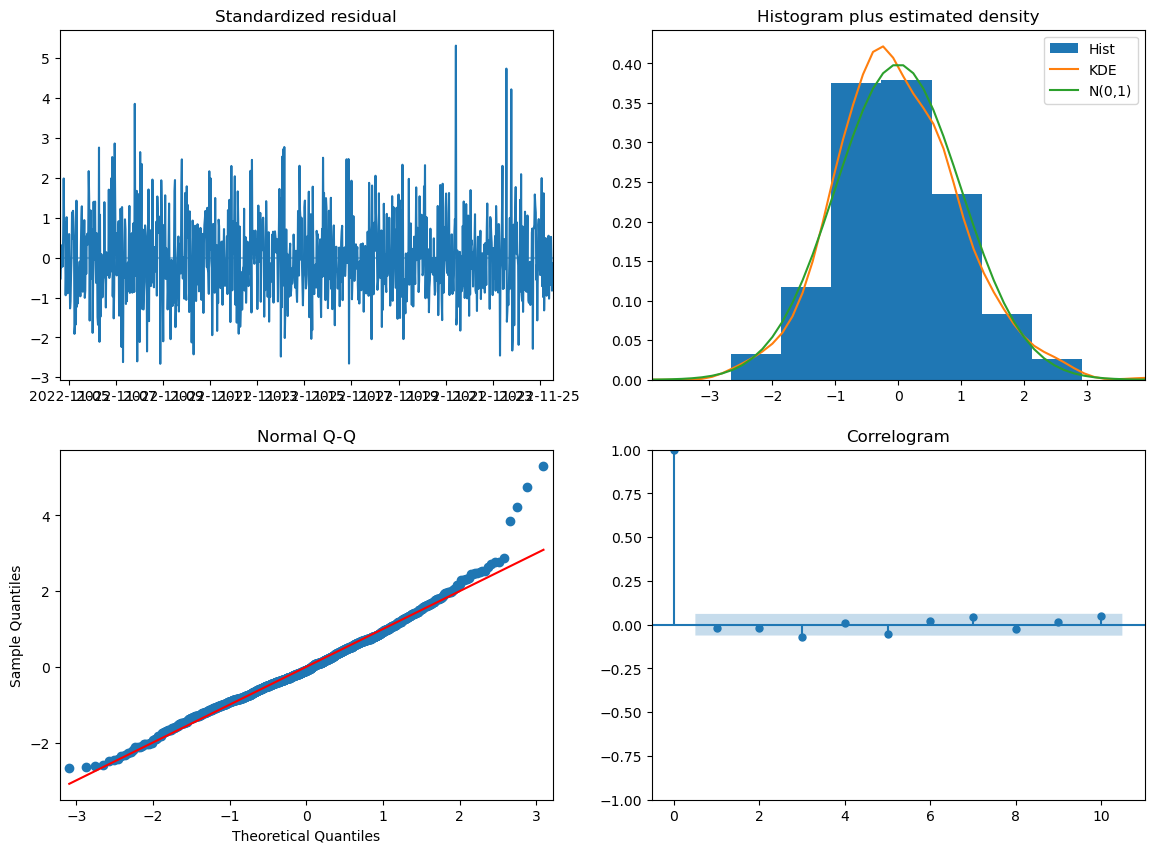

In [14]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [15]:
# calculate SMAPE (Symmetric Mean Absolute Error)
def calcsmape(actual, forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast)))

In [17]:
smape=calcsmape(test.VH2O_M,prediction)
smape


0.4882808029556261